# 07 - TF-IDF + Logistic Regression Baseline

**Approach 6**: Simple interpretable baseline.

This notebook implements a bag-of-words approach with TF-IDF weighting and Logistic Regression.

## Target Predictions
- **Department (Domain)**: The professional domain of the current job
- **Seniority**: The seniority level of the current position

## Why This Approach?
- **Interpretable**: Coefficients show which words matter for each class
- **Fast**: No deep learning, trains in seconds
- **Baseline**: Sets a minimum bar for more complex models

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.loader import load_linkedin_data, prepare_dataset
from src.models.feature_ml import TFIDFClassifier, TFIDFConfig

DATA_DIR = Path('../data')
MODELS_DIR = Path('../models')
RANDOM_STATE = 42

print("Setup complete!")

Setup complete!


## 1. Load Data

In [2]:
# Load annotated CVs
cvs_annotated = load_linkedin_data(DATA_DIR / 'linkedin-cvs-annotated.json')
print(f"Loaded {len(cvs_annotated)} annotated CVs")

# Prepare dataset - extracts ACTIVE positions with department and seniority labels
df = prepare_dataset(cvs_annotated, include_history=True)
print(f"Dataset shape: {df.shape}")
print(f"\nTarget labels:")
print(f"  - Department (domain): {df['department'].nunique()} unique classes")
print(f"  - Seniority: {df['seniority'].nunique()} unique classes")
df.head()

Loaded 609 annotated CVs
Dataset shape: (478, 7)

Target labels:
  - Department (domain): 11 unique classes
  - Seniority: 6 unique classes


,cv_id,title,company,text,department,seniority,history
0,0,Prokurist,Depot4Design GmbH,Prokurist at Depot4Design GmbH,Other,Management,Buchhalterin
1,1,Solutions Architect,Computer Solutions,Solutions Architect at Computer Solutions,Information Technology,Professional,Senior Network Engineer | Manager of Network S...
2,2,Medizintechnik Beratung,Udo Weber,Medizintechnik Beratung at Udo Weber,Consulting,Professional,Projektleiter Medizintechnik | Nationaler Acco...
3,3,Director expansión de negocio.,Grupo Viajes Kontiki.,Director expansión de negocio. at Grupo Viajes...,Business Development,Director,Gerente general comercial | Director Desarroll...
4,4,"APL-ansvarig, samordning",Himmelstalunds Utbildningscentrum,"APL-ansvarig, samordning at Himmelstalunds Utb...",Administrative,Lead,Utbildningsledare inom Servicekunskap och Förs...


In [3]:
# Check label distributions
print("Department (Domain) distribution:")
print(df['department'].value_counts())
print(f"\nSeniority distribution:")
print(df['seniority'].value_counts())

Department (Domain) distribution:
department
Other                     250
Information Technology     55
Sales                      37
Project Management         31
Consulting                 28
Marketing                  18
Business Development       17
Human Resources            15
Purchasing                 12
Administrative              9
Customer Support            6
Name: count, dtype: int64

Seniority distribution:
seniority
Professional    161
Management      138
Lead            103
Senior           39
Director         27
Junior           10
Name: count, dtype: int64


## 2. Train/Test Split

In [4]:
# Create indices for train/test split
indices = np.arange(len(df))

train_idx, test_idx = train_test_split(
    indices, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=df['department']
)

print(f"Train size: {len(train_idx)}")
print(f"Test size: {len(test_idx)}")

# Prepare data splits
train_texts = df.iloc[train_idx]['text'].tolist()
test_texts = df.iloc[test_idx]['text'].tolist()

# Target 1: Department (Domain)
train_dept = df.iloc[train_idx]['department'].tolist()
test_dept = df.iloc[test_idx]['department'].tolist()

# Target 2: Seniority
train_seniority = df.iloc[train_idx]['seniority'].tolist()
test_seniority = df.iloc[test_idx]['seniority'].tolist()

Train size: 382
Test size: 96


## 3. Train TF-IDF + Logistic Regression

Train separate classifiers for department (domain) and seniority.

In [5]:
# Configure TF-IDF + Logistic Regression
tfidf_config = TFIDFConfig(
    max_features=3000,
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,
    max_df=0.95,
    classifier_type='logistic'
)

# Train DEPARTMENT (domain) classifier
print("Training Department (Domain) classifier...")
dept_classifier = TFIDFClassifier(config=tfidf_config)
dept_classifier.fit(train_texts, train_dept)

# Train SENIORITY classifier
print("Training Seniority classifier...")
seniority_classifier = TFIDFClassifier(config=tfidf_config)
seniority_classifier.fit(train_texts, train_seniority)

print("\nBoth classifiers trained!")

Training Department (Domain) classifier...
Training Seniority classifier...

Both classifiers trained!


## 4. Evaluation

Evaluate both classifiers on the test set.

In [6]:
# Predictions for both targets
dept_pred = dept_classifier.predict(test_texts)
seniority_pred = seniority_classifier.predict(test_texts)

print("=" * 60)
print("TF-IDF + LOGISTIC REGRESSION RESULTS")
print("=" * 60)

print("\n" + "=" * 60)
print("TARGET 1: DEPARTMENT (DOMAIN) CLASSIFICATION")
print("=" * 60)
print(f"Accuracy: {accuracy_score(test_dept, dept_pred):.4f}")
print("\nClassification Report:")
print(classification_report(test_dept, dept_pred))

print("\n" + "=" * 60)
print("TARGET 2: SENIORITY CLASSIFICATION")
print("=" * 60)
print(f"Accuracy: {accuracy_score(test_seniority, seniority_pred):.4f}")
print("\nClassification Report:")
print(classification_report(test_seniority, seniority_pred))

TF-IDF + LOGISTIC REGRESSION RESULTS

TARGET 1: DEPARTMENT (DOMAIN) CLASSIFICATION
Accuracy: 0.5729

Classification Report:
                        precision    recall  f1-score   support

        Administrative       0.00      0.00      0.00         2
  Business Development       0.75      1.00      0.86         3
            Consulting       1.00      0.67      0.80         6
      Customer Support       0.00      0.00      0.00         1
       Human Resources       0.00      0.00      0.00         3
Information Technology       0.50      0.64      0.56        11
             Marketing       0.18      0.50      0.27         4
                 Other       0.79      0.66      0.72        50
    Project Management       0.40      0.33      0.36         6
            Purchasing       0.25      0.50      0.33         2
                 Sales       0.43      0.38      0.40         8

              accuracy                           0.57        96
             macro avg       0.39      0.4

## 5. Interpretability: Feature Coefficients

The key advantage of Logistic Regression is interpretability - we can see which words drive each class.

In [7]:
# Top features per DEPARTMENT class (which words indicate which department?)
print("Top 10 words per DEPARTMENT (Domain) class:")
dept_importance = dept_classifier.get_feature_importances(top_n=10)
dept_importance

Top 10 words per DEPARTMENT (Domain) class:


,Administrative,Business Development,Consulting,Customer Support,Human Resources,Information Technology,Marketing,Other,Project Management,Purchasing,Sales
0,buroleiter,partner,consultant,service,hr,it,marketing,geschaftsfuhrer,project,purchasing,sales
1,office,partner at,consultant at,customer,human,engineer,ag,ceo,projektleiter,procurement,account
2,at hotel,strategic,leader,service manager,human resources,engineer at,communications,ceo at,project manager,der,vertrieb
3,responsable,strategy,senior consultant,at siemens,resources,cto,of marketing,geschaftsfuhrer at,und,purchasing manager,account manager
4,de,business,switzerland,siemens,talent,cto at,marketing at,gmbh,sub,equipment,of sales
5,manager,business development,and,at fedex,company,architect,digital,managing,projektmanager,food,vertrieb at
6,dr,director,berater,fedex,manager at,software,emea,director at,management at,team,control
7,buro,expansion,business,specialist at,department at,technologies,design,general,aps,quality,sales manager
8,hotel,new,data,specialist,department,engineering,designer,purchasing,senior project,vp,co
9,manager at,development,strategy,commercial,specialist,university,designer at,general manager,management,senior manager,gmbh


In [8]:
# Top features per SENIORITY class
print("Top 10 words per SENIORITY class:")
seniority_importance = seniority_classifier.get_feature_importances(top_n=10)
seniority_importance

Top 10 words per SENIORITY class:


,Director,Junior,Lead,Management,Professional,Senior
0,director,referent,head,geschaftsfuhrer,senior,senior
1,director of,brunswick,head of,ceo,director,senior manager
2,construction,frankfurt,director,ceo at,manager,at siemens
3,managing,universitat,senior,managing,referent,siemens
4,vr,des,leiter,managing director,consultant,architect at
5,at vr,public,lead,partner,consultant at,senior consultant
6,vertrieb at,le,projektleiter,geschaftsfuhrer at,hr,architect
7,and,real estate,und,president,manager at,at airbus
8,vertrieb,real,it,general manager,geschaftsfuhrer,airbus
9,europe,estate,leader,owner,director at,purchasing


## 6. Confusion Matrices

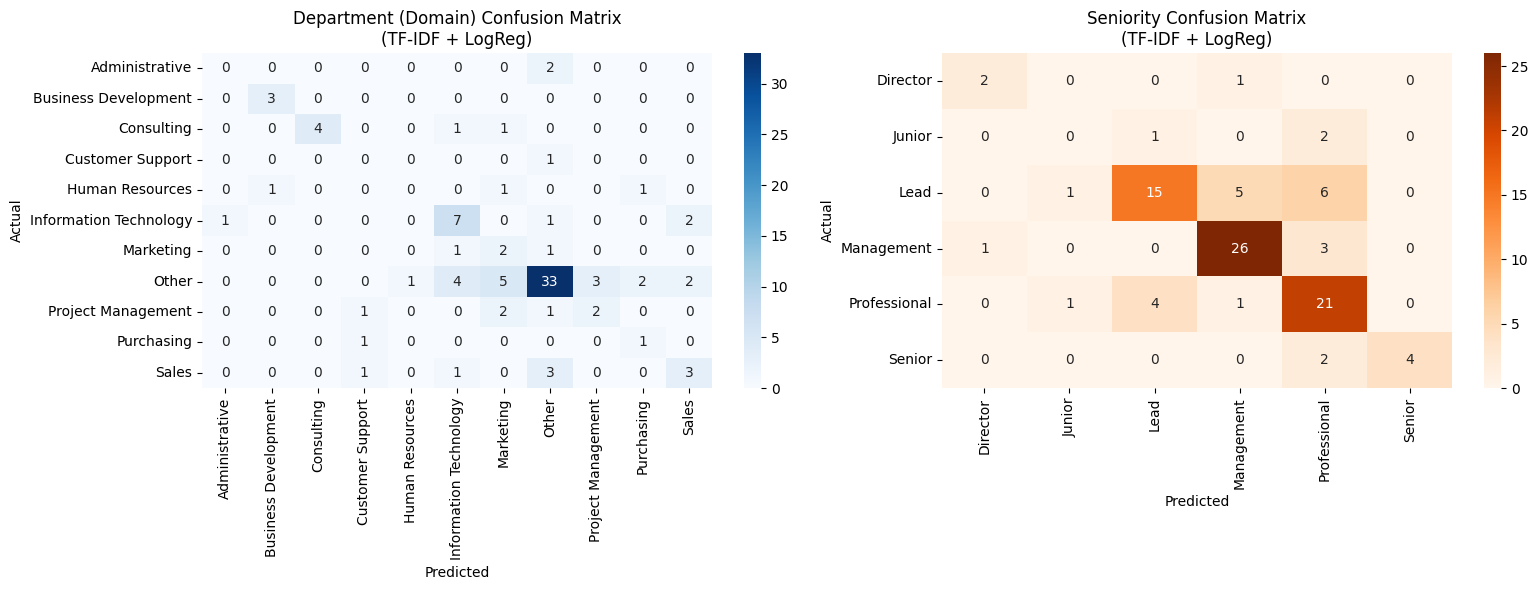

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Department confusion matrix
cm_dept = confusion_matrix(test_dept, dept_pred, labels=sorted(set(test_dept)))
sns.heatmap(cm_dept, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(test_dept)), 
            yticklabels=sorted(set(test_dept)), ax=axes[0])
axes[0].set_title('Department (Domain) Confusion Matrix\n(TF-IDF + LogReg)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Seniority confusion matrix
cm_seniority = confusion_matrix(test_seniority, seniority_pred, labels=sorted(set(test_seniority)))
sns.heatmap(cm_seniority, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sorted(set(test_seniority)),
            yticklabels=sorted(set(test_seniority)), ax=axes[1])
axes[1].set_title('Seniority Confusion Matrix\n(TF-IDF + LogReg)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('results/07_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Hyperparameter Exploration

Compare different n-gram ranges for both targets.

In [10]:
# Compare different n-gram ranges for BOTH department and seniority
ngram_results = []

for ngram_range in [(1, 1), (1, 2), (1, 3)]:
    config = TFIDFConfig(
        max_features=3000,
        ngram_range=ngram_range,
        classifier_type='logistic'
    )
    
    # Train and evaluate DEPARTMENT classifier
    dept_clf = TFIDFClassifier(config=config)
    dept_clf.fit(train_texts, train_dept)
    dept_acc = accuracy_score(test_dept, dept_clf.predict(test_texts))
    
    # Train and evaluate SENIORITY classifier
    seniority_clf = TFIDFClassifier(config=config)
    seniority_clf.fit(train_texts, train_seniority)
    seniority_acc = accuracy_score(test_seniority, seniority_clf.predict(test_texts))
    
    ngram_results.append({
        'ngram_range': str(ngram_range),
        'department_accuracy': dept_acc,
        'seniority_accuracy': seniority_acc
    })
    print(f"N-gram {ngram_range}: Dept={dept_acc:.4f}, Seniority={seniority_acc:.4f}")

pd.DataFrame(ngram_results)

N-gram (1, 1): Dept=0.5521, Seniority=0.7396
N-gram (1, 2): Dept=0.5729, Seniority=0.7083
N-gram (1, 3): Dept=0.5729, Seniority=0.7083


,ngram_range,department_accuracy,seniority_accuracy
0,"(1, 1)",0.552083,0.739583
1,"(1, 2)",0.572917,0.708333
2,"(1, 3)",0.572917,0.708333


## 8. Save Models

In [11]:
MODELS_DIR.mkdir(exist_ok=True)

# Save both classifiers
dept_classifier.save(MODELS_DIR / 'tfidf_logreg_department.pkl')
seniority_classifier.save(MODELS_DIR / 'tfidf_logreg_seniority.pkl')

print("Models saved:")
print("  - tfidf_logreg_department.pkl")
print("  - tfidf_logreg_seniority.pkl")

Models saved:
  - tfidf_logreg_department.pkl
  - tfidf_logreg_seniority.pkl


## Summary

This notebook implemented **Approach 6: Simple Interpretable Baseline** using TF-IDF + Logistic Regression.

### Predictions Made:
1. **Department (Domain)**: Professional domain of the current ACTIVE job
2. **Seniority**: Seniority level of the current ACTIVE position

### Key Findings:
- Simple bag-of-words approach provides a reasonable baseline
- Logistic Regression coefficients reveal interpretable patterns
- Job title text (e.g., "Software", "Manager") carries strong classification signal
- Bigrams (1,2) often outperform unigrams alone